In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Point, box
import datetime as dt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import SplineTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV
from numpy import trapz
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
nodes = pd.read_csv("node_data.csv")
edges = pd.read_csv("edges_data.csv")
df_2020 = pd.read_csv("data/scats_detector_volume_jan-jun-2020.csv")
sites = pd.read_csv("data/its_scats_sites_aug-2020.csv")
columns_to_load = ["End_Time", "Site", "Detector", "Sum_Volume", "Avg_Volume"]
March2025 = pd.read_csv("data/SCATSMarch2025.csv", usecols=columns_to_load)
April2025 = pd.read_csv("data/SCATSApril2025.csv", usecols=columns_to_load)
May2025 = pd.read_csv("data/SCATSMay2025.csv", usecols=columns_to_load)

In [4]:
df  = pd.concat([March2025, April2025], ignore_index=True)
geo_edges=edges.copy()
# Convert the 'geometry' column from WKT to Shapely geometries
geo_edges['geometry'] = edges['geometry'].apply(wkt.loads)

# Wrap as a GeoDataFrame
geo_edges = gpd.GeoDataFrame(geo_edges, geometry='geometry')

# Set the CRS (optional, replace with your CRS if known)
geo_edges.set_crs(epsg=4326, inplace=True)

# Now this is a true GeoDataFrame
print(type(geo_edges))
geo_nodes=nodes.copy()
# Convert the 'geometry' column from WKT to Shapely geometries
geo_nodes['geometry'] = nodes['geometry'].apply(wkt.loads)

# Wrap as a GeoDataFrame
geo_nodes = gpd.GeoDataFrame(geo_nodes, geometry='geometry')

# Set the CRS (optional, replace with your CRS if known)
geo_nodes.set_crs(epsg=4326, inplace=True)

# Now this is a true GeoDataFrame
print(type(geo_nodes))
sites = sites[~((sites["Lat"] == 0) | (sites["Long"] == 0))]
geo_sites = gpd.GeoDataFrame(
    sites,
    geometry=gpd.points_from_xy(sites['Long'], sites['Lat']),
    crs="EPSG:4326"  # WGS84 coordinate system (lat/long)
)
# Get bounding box of all points
minx, miny, maxx, maxy = geo_edges.total_bounds

# Define grid size (in the CRS units, e.g., degrees if EPSG:4326)
nx = 10  # number of columns
ny = 10  # number of rows
xgrid = np.linspace(minx, maxx, nx+1)
ygrid = np.linspace(miny, maxy, ny+1)

# Create grid polygons
polygons = []
for i in range(nx):
    for j in range(ny):
        polygons.append(box(xgrid[i], ygrid[j], xgrid[i+1], ygrid[j+1]))

grid = gpd.GeoDataFrame({'geometry': polygons}, crs=geo_edges.crs)
df_small = df[["End_Time","Site","Detector","Sum_Volume"]]  # only necessary columns
geo_small = geo_sites[['SiteID', 'geometry']]
df_small['Site'] = df_small['Site'].astype('category')
geo_small['SiteID'] = geo_small['SiteID'].astype('category')
gdf = pd.merge(df_small, geo_small, left_on ="Site", right_on = "SiteID", how = "inner")
gdf=gdf.drop("SiteID", axis = 1)
gdf["End_Time"] = pd.to_datetime(gdf["End_Time"], format="%Y%m%d%H%M%S")
gdf = gpd.GeoDataFrame(
    gdf,
    geometry=gdf["geometry"],
    crs="EPSG:4326"  # WGS84 coordinate system (lat/long)
)
gdf.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'geopandas.geodataframe.GeoDataFrame'>


C:\Users\user1\AppData\Local\Temp\ipykernel_10676\3287620885.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_small['Site'] = df_small['Site'].astype('category')
c:\Users\user1\AppData\Local\Programs\Python\Python313\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,End_Time,Site,Detector,Sum_Volume,geometry
0,2025-03-13 01:00:00,58,6,0,POINT (-6.26523 53.35605)
1,2025-03-13 01:00:00,58,7,5,POINT (-6.26523 53.35605)
2,2025-03-13 01:00:00,58,8,0,POINT (-6.26523 53.35605)
3,2025-03-13 01:00:00,58,9,0,POINT (-6.26523 53.35605)
4,2025-03-13 01:00:00,58,10,0,POINT (-6.26523 53.35605)


In [140]:
May_small = May2025[["End_Time","Site","Detector","Sum_Volume"]]  # only necessary columns
geo_small = geo_sites[['SiteID', 'geometry']]
May_small['Site'] = May_small['Site'].astype('category')
geo_small['SiteID'] = geo_small['SiteID'].astype('category')
gdf_May = pd.merge(May_small, geo_small, left_on ="Site", right_on = "SiteID", how = "inner")
gdf_May=gdf_May.drop("SiteID", axis = 1)
gdf_May["End_Time"] = pd.to_datetime(gdf_May["End_Time"], format="%Y%m%d%H%M%S")
gdf_May = gpd.GeoDataFrame(
    gdf_May,
    geometry=gdf_May["geometry"],
    crs="EPSG:4326"  # WGS84 coordinate system (lat/long)
)
gdf_May.head()

C:\Users\user1\AppData\Local\Temp\ipykernel_10676\3299648080.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  May_small['Site'] = May_small['Site'].astype('category')
c:\Users\user1\AppData\Local\Programs\Python\Python313\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,End_Time,Site,Detector,Sum_Volume,geometry
0,2025-05-26 02:00:00,403,21,0,POINT (-6.25345 53.34944)
1,2025-05-26 02:00:00,403,22,0,POINT (-6.25345 53.34944)
2,2025-05-26 02:00:00,403,23,0,POINT (-6.25345 53.34944)
3,2025-05-26 02:00:00,403,24,0,POINT (-6.25345 53.34944)
4,2025-05-26 02:00:00,404,1,2,POINT (-6.29184 53.34775)


In [141]:
joined_may = gpd.sjoin(gdf_May, grid, how='left', predicate='within')
joined_may = joined_may.rename(columns={"index_right": "Grid_ID"})
joined_may.head()

,End_Time,Site,Detector,Sum_Volume,geometry,Grid_ID,Sum_volume
0,2025-05-26 02:00:00,403,21,0,POINT (-6.25345 53.34944),54.0,37195178.0
1,2025-05-26 02:00:00,403,22,0,POINT (-6.25345 53.34944),54.0,37195178.0
2,2025-05-26 02:00:00,403,23,0,POINT (-6.25345 53.34944),54.0,37195178.0
3,2025-05-26 02:00:00,403,24,0,POINT (-6.25345 53.34944),54.0,37195178.0
4,2025-05-26 02:00:00,404,1,2,POINT (-6.29184 53.34775),34.0,10481274.0


In [5]:
# Spatial join points to grid boxes
joined = gpd.sjoin(gdf, grid, how='left', predicate='within')
joined = joined.rename(columns={"index_right": "Grid_ID"})

# Sum Sum_volume per grid cell
grid_sum = joined.groupby('Grid_ID')['Sum_Volume'].sum()

# Assign sums to the grid GeoDataFrame
grid['Sum_volume'] = grid_sum
grid['Sum_volume'] = grid['Sum_volume'].fillna(0)  # fill empty cells
joined.head()

,End_Time,Site,Detector,Sum_Volume,geometry,Grid_ID
0,2025-03-13 01:00:00,58,6,0,POINT (-6.26523 53.35605),45.0
1,2025-03-13 01:00:00,58,7,5,POINT (-6.26523 53.35605),45.0
2,2025-03-13 01:00:00,58,8,0,POINT (-6.26523 53.35605),45.0
3,2025-03-13 01:00:00,58,9,0,POINT (-6.26523 53.35605),45.0
4,2025-03-13 01:00:00,58,10,0,POINT (-6.26523 53.35605),45.0


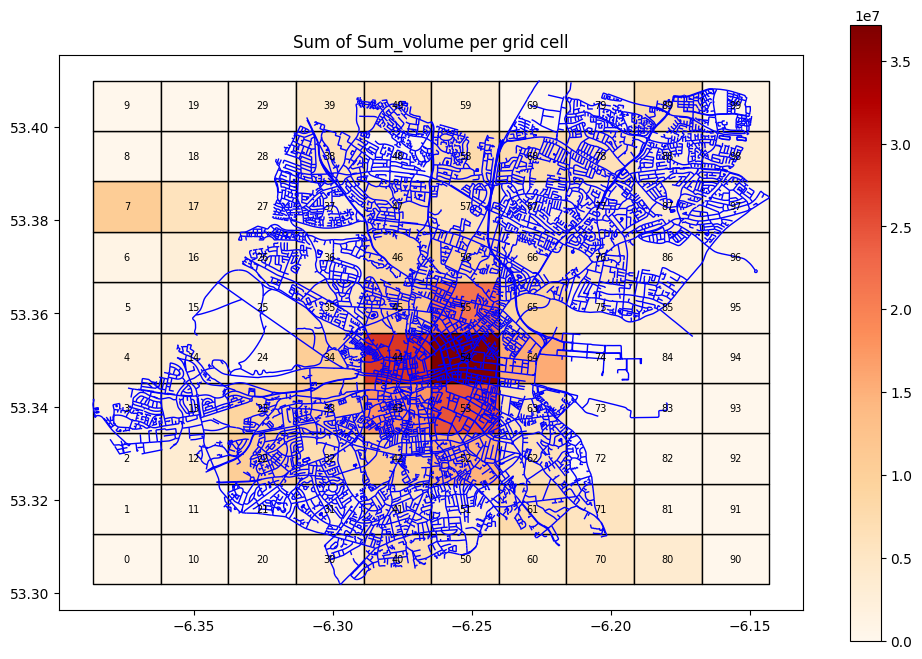

In [73]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
grid.plot(column='Sum_volume', ax=ax, cmap='OrRd', legend=True, edgecolor='k')
geo_edges.plot(ax=ax, color='blue', linewidth=1, label='Edges')

for idx, row in grid.iterrows():
    if row.geometry is not None and not row.geometry.is_empty:
        x, y = row.geometry.centroid.coords[0]
        ax.text(x, y, str(row.name), fontsize=7, color="black",
                ha="center", va="center")
        
plt.title("Sum of Sum_volume per grid cell")
plt.show()

In [6]:
joined_eval = joined.groupby(["Grid_ID","End_Time"]).agg({
    "Sum_Volume": "sum"
}).reset_index()
joined_eval = joined_eval.sort_values("Grid_ID")
joined_eval.head()

,Grid_ID,End_Time,Sum_Volume
0,3.0,2025-03-01 00:00:00,897
1,3.0,2025-03-01 01:00:00,551
2,3.0,2025-03-01 02:00:00,492
3,3.0,2025-03-01 03:00:00,272
4,3.0,2025-03-01 04:00:00,247


In [142]:
may_eval = joined_may.groupby(["Grid_ID","End_Time"]).agg({
    "Sum_Volume": "sum"
}).reset_index()
may_eval = may_eval.sort_values("Grid_ID")
may_eval.head()

,Grid_ID,End_Time,Sum_Volume
0,3.0,2025-05-01 00:00:00,626
1,3.0,2025-05-01 01:00:00,377
2,3.0,2025-05-01 02:00:00,200
3,3.0,2025-05-01 03:00:00,148
4,3.0,2025-05-01 04:00:00,127


In [143]:
may_eval["Vol_diff"] = may_eval["Sum_Volume"].diff().fillna(0)
may_eval['weekday'] = may_eval["End_Time"].dt.dayofweek
may_eval=may_eval[~may_eval["Grid_ID"].isin([72,73])]
may_eval.head()

,Grid_ID,End_Time,Sum_Volume,Vol_diff,weekday
0,3.0,2025-05-01 00:00:00,626,0.0,3
1,3.0,2025-05-01 01:00:00,377,-249.0,3
2,3.0,2025-05-01 02:00:00,200,-177.0,3
3,3.0,2025-05-01 03:00:00,148,-52.0,3
4,3.0,2025-05-01 04:00:00,127,-21.0,3


In [144]:
may_weekdays = may_eval[may_eval["weekday"].isin(range(0,5))].copy()
may_saturdays = may_eval[may_eval["weekday"] == 5].copy()
may_sundays = may_eval[may_eval["weekday"] == 6].copy()

In [104]:
joined_eval["Vol_diff"] = joined_eval["Sum_Volume"].diff().fillna(0)
joined_eval['weekday'] = joined_eval["End_Time"].dt.dayofweek
joined_eval=joined_eval[~joined_eval["Grid_ID"].isin([72,73])]
joined_eval.head()

,Grid_ID,End_Time,Sum_Volume,Vol_diff,weekday
0,3.0,2025-03-01 00:00:00,897,0.0,5
1,3.0,2025-03-01 01:00:00,551,-346.0,5
2,3.0,2025-03-01 02:00:00,492,-59.0,5
3,3.0,2025-03-01 03:00:00,272,-220.0,5
4,3.0,2025-03-01 04:00:00,247,-25.0,5


In [105]:
joined_eval.columns

Index(['Grid_ID', 'End_Time', 'Sum_Volume', 'Vol_diff', 'weekday'], dtype='object')

In [106]:
weekdays = joined_eval[joined_eval["weekday"].isin(range(0,5))].copy()
saturdays = joined_eval[joined_eval["weekday"] == 5].copy()
sundays = joined_eval[joined_eval["weekday"] == 6].copy()

In [107]:
grid_id=54
df_weekdays = weekdays[weekdays["Grid_ID"] == grid_id].copy()
df_sat = saturdays[saturdays["Grid_ID"] == grid_id].copy()
df_sun = sundays[sundays["Grid_ID"] == grid_id].copy()

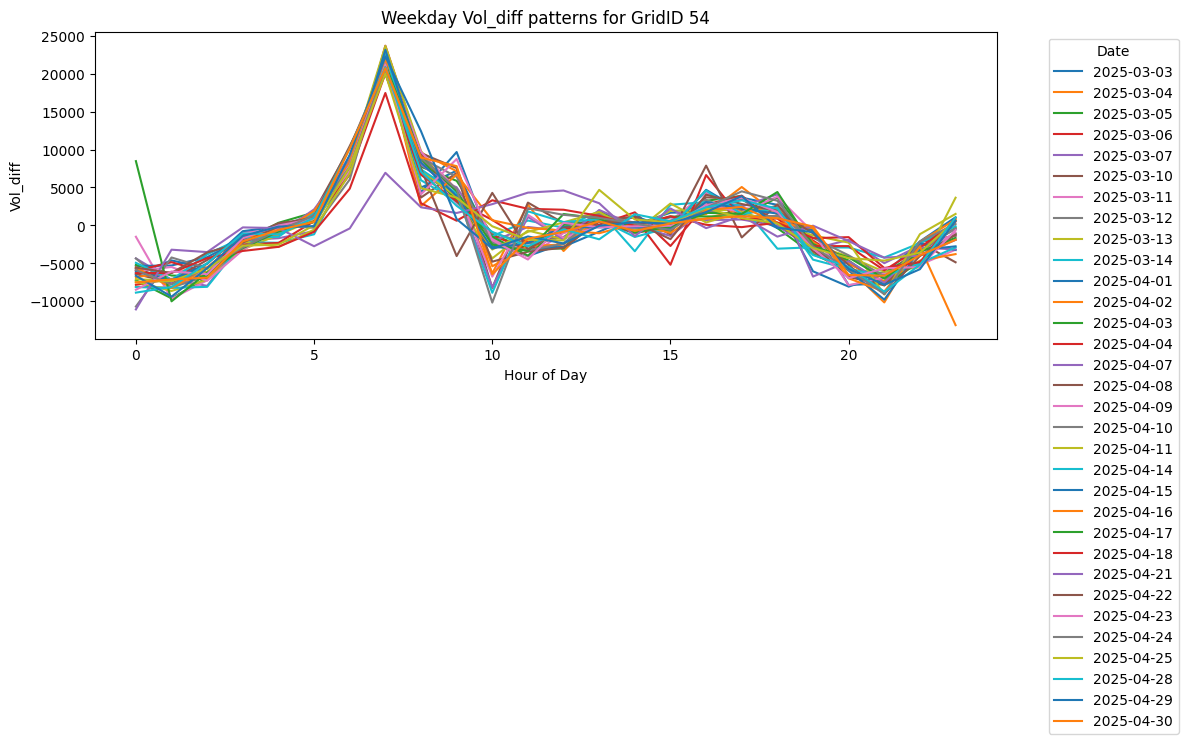

In [108]:

df_weekdays['date'] = df_weekdays['End_Time'].dt.date
df_weekdays['hour'] = df_weekdays['End_Time'].dt.hour  # or use End_Time directly if hourly

# Plot each day on the same graph
plt.figure(figsize=(12,6))
for date, group in df_weekdays.groupby('date'):
    plt.plot(group['hour'], group['Vol_diff'], label=str(date))

plt.xlabel("Hour of Day")
plt.ylabel("Vol_diff")
plt.title(f"Weekday Vol_diff patterns for GridID {grid_id}")
plt.legend(title="Date", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [109]:

integrals = {}

for date, group in df_weekdays.groupby('date'):
    # Make sure values are sorted in time
    group = group.sort_values('End_Time')
    
    # x = time in hours since start of the day
    x = (group['End_Time'] - group['End_Time'].min()).dt.total_seconds() / 3600
    y = group['Vol_diff'].values
    
    # Trapezoidal integration
    integral = np.trapz(y, x)
    integrals[date] = integral

# Convert to DataFrame
daily_integrals = pd.DataFrame(list(integrals.items()), columns=['date', 'integral'])
print(daily_integrals)


          date  integral
0   2025-03-03    8627.0
1   2025-03-04    5522.0
2   2025-03-05    3065.5
3   2025-03-06    6071.5
4   2025-03-07    5257.5
5   2025-03-10    5249.0
6   2025-03-11    4415.0
7   2025-03-12    8248.0
8   2025-03-13    6993.5
9   2025-03-14    2031.5
10  2025-04-01    8929.0
11  2025-04-02    5146.5
12  2025-04-03    7338.5
13  2025-04-04    7524.0
14  2025-04-07    4059.0
15  2025-04-08    8094.0
16  2025-04-09    6045.0
17  2025-04-10    8576.5
18  2025-04-11    6153.5
19  2025-04-14    4750.0
20  2025-04-15    7197.5
21  2025-04-16    -358.0
22  2025-04-17   12039.5
23  2025-04-18    2138.0
24  2025-04-21   -1429.5
25  2025-04-22    8773.5
26  2025-04-23    4662.0
27  2025-04-24    8230.5
28  2025-04-25    4634.5
29  2025-04-28    3147.0
30  2025-04-29    4016.5
31  2025-04-30    3563.0


C:\Users\user1\AppData\Local\Temp\ipykernel_10676\3977370359.py:12: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integral = np.trapz(y, x)


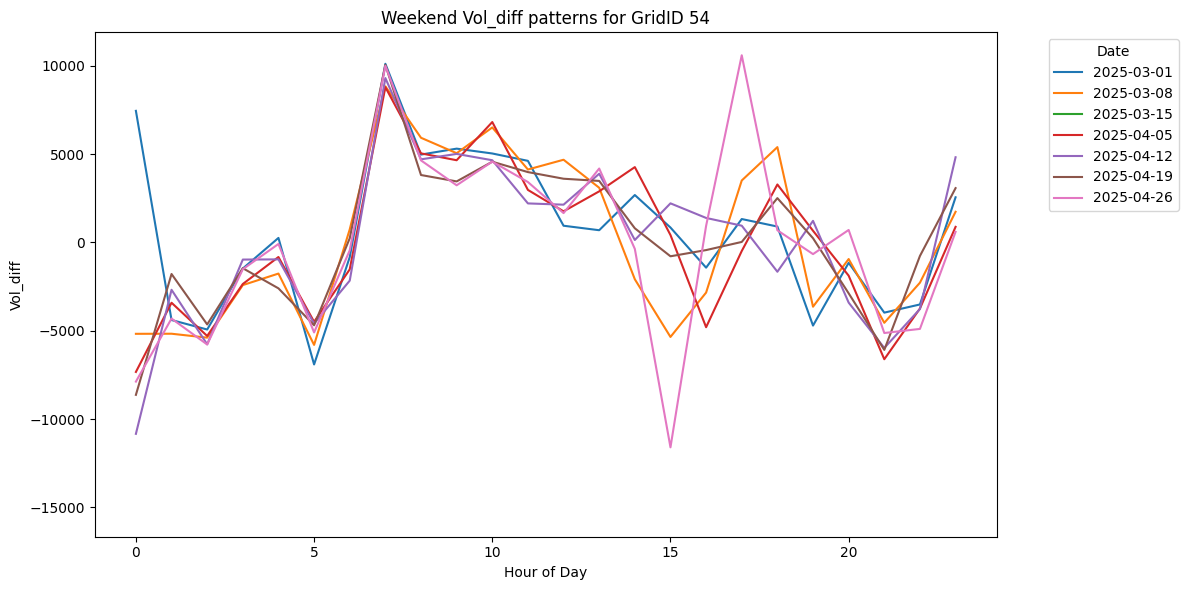

In [110]:

df_sat['date'] = df_sat['End_Time'].dt.date
df_sat['hour'] = df_sat['End_Time'].dt.hour  # or use End_Time directly if hourly

# Plot each day on the same graph
plt.figure(figsize=(12,6))
for date, group in df_sat.groupby('date'):
    plt.plot(group['hour'], group['Vol_diff'], label=str(date))

plt.xlabel("Hour of Day")
plt.ylabel("Vol_diff")
plt.title(f"Weekend Vol_diff patterns for GridID {grid_id}")
plt.legend(title="Date", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [111]:
integrals_sat = {}

for date, group in df_sat.groupby('date'):
    # Make sure values are sorted in time
    group = group.sort_values('End_Time')
    
    # x = time in hours since start of the day
    x = (group['End_Time'] - group['End_Time'].min()).dt.total_seconds() / 3600
    y = group['Vol_diff'].values
    
    # Trapezoidal integration
    integral = np.trapz(y, x)
    integrals_sat[date] = integral

# Convert to DataFrame
daily_integrals_sat = pd.DataFrame(list(integrals_sat.items()), columns=['date', 'integral'])
print(daily_integrals_sat)

         date  integral
0  2025-03-01    9399.5
1  2025-03-08    3947.0
2  2025-03-15       0.0
3  2025-04-05    2919.5
4  2025-04-12    2883.0
5  2025-04-19    7887.0
6  2025-04-26    1137.0


C:\Users\user1\AppData\Local\Temp\ipykernel_10676\1937423952.py:12: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integral = np.trapz(y, x)


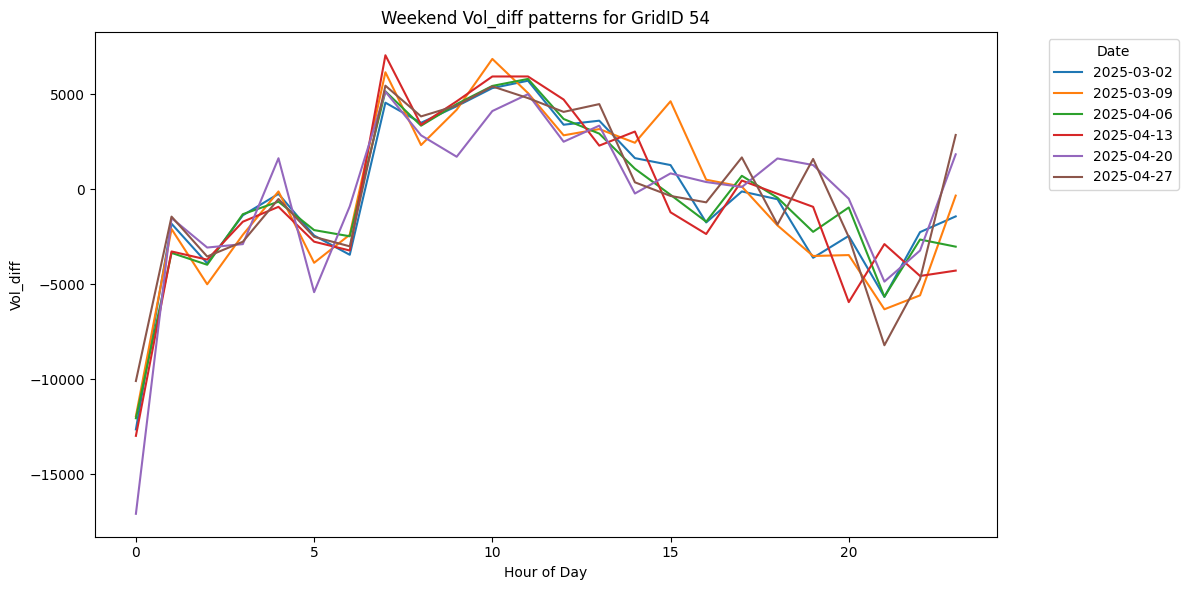

In [112]:

df_sun['date'] = df_sun['End_Time'].dt.date
df_sun['hour'] = df_sun['End_Time'].dt.hour  # or use End_Time directly if hourly

# Plot each day on the same graph
plt.figure(figsize=(12,6))
for date, group in df_sun.groupby('date'):
    plt.plot(group['hour'], group['Vol_diff'], label=str(date))

plt.xlabel("Hour of Day")
plt.ylabel("Vol_diff")
plt.title(f"Weekend Vol_diff patterns for GridID {grid_id}")
plt.legend(title="Date", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [113]:
integrals_sun = {}

for date, group in df_sun.groupby('date'):
    # Make sure values are sorted in time
    group = group.sort_values('End_Time')
    
    # x = time in hours since start of the day
    x = (group['End_Time'] - group['End_Time'].min()).dt.total_seconds() / 3600
    y = group['Vol_diff'].values
    
    # Trapezoidal integration
    integral = np.trapz(y, x)
    integrals_sun[date] = integral

# Convert to DataFrame
daily_integrals_sun = pd.DataFrame(list(integrals_sun.items()), columns=['date', 'integral'])
print(daily_integrals_sun)

         date  integral
0  2025-03-02   -3072.5
1  2025-03-09   -4308.5
2  2025-04-06   -2588.0
3  2025-04-13   -4722.5
4  2025-04-20     468.0
5  2025-04-27     519.5


C:\Users\user1\AppData\Local\Temp\ipykernel_10676\1795947066.py:12: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integral = np.trapz(y, x)


In [114]:
def fit_fourier(df, n_harmonics):
    """
    Fit Fourier series to Vol_diff as a function of hour-of-day.
    Returns model and dataframe with fitted curve.
    """
    # Ensure datetime
    df['End_Time'] = pd.to_datetime(df['End_Time'])
    df['hour'] = df['End_Time'].dt.hour
    
    # Collapse by average per hour (so all days align)
    hourly = df.groupby('hour')['Vol_diff'].mean().reset_index()
    X = []
    
    for k in range(1, n_harmonics+1):
        hourly[f'sin{k}'] = np.sin(2*np.pi*k*hourly['hour']/24)
        hourly[f'cos{k}'] = np.cos(2*np.pi*k*hourly['hour']/24)
        X.append(hourly[[f'sin{k}', f'cos{k}']])
    
    X = pd.concat(X, axis=1)
    
    # Fit regression
    model = LinearRegression()
    model.fit(X, hourly['Vol_diff'])
    
    # Predict smooth curve
    hours = np.linspace(0, 23, 200)
    X_pred = []
    for k in range(1, n_harmonics+1):
        X_pred.append(pd.DataFrame({
            f'sin{k}': np.sin(2*np.pi*k*hours/24),
            f'cos{k}': np.cos(2*np.pi*k*hours/24)
        }))
    X_pred = pd.concat(X_pred, axis=1)
    y_pred = model.predict(X_pred)
    
    return hourly, hours, y_pred, model

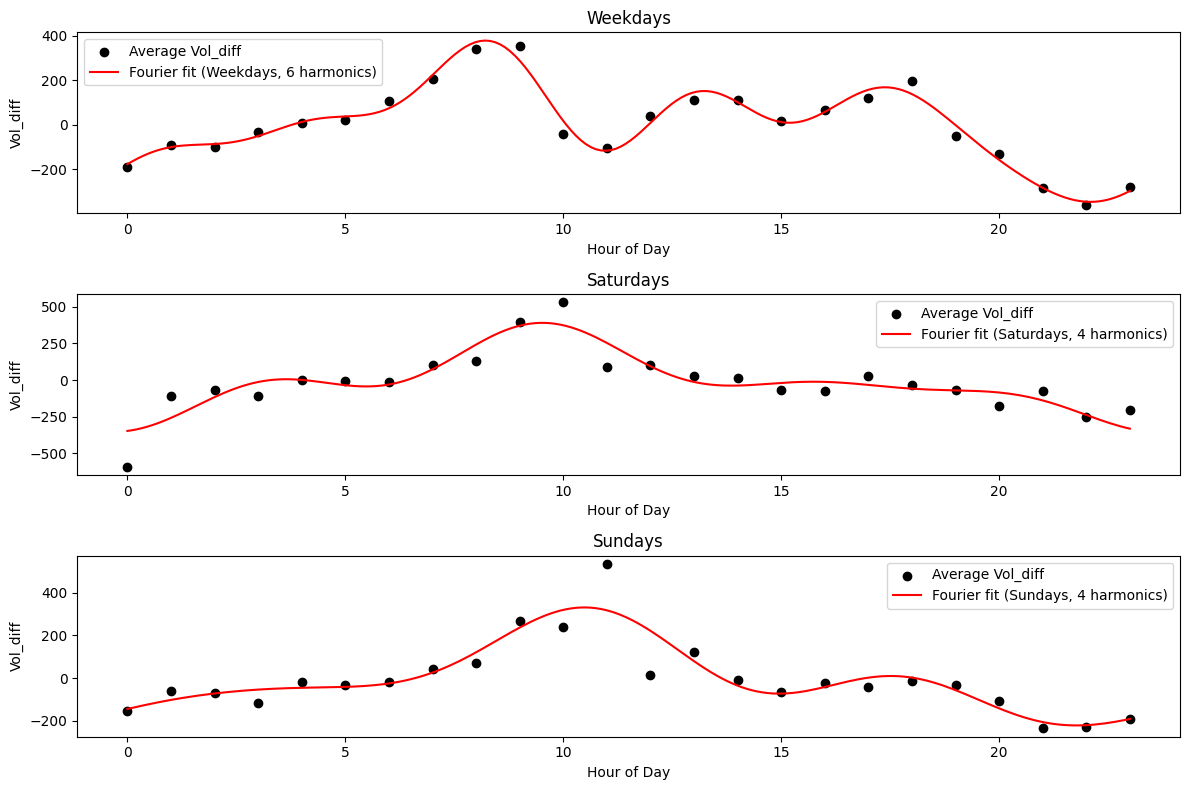

In [129]:
# Store results here
results = {}

groups = {
    "Weekdays": df_weekdays,
    "Saturdays": df_sat,
    "Sundays": df_sun
}

# Define harmonics per group
harmonics_map = {
    "Weekdays": 6,
    "Saturdays": 4,
    "Sundays": 4
}

plt.figure(figsize=(12, 8))

for i, (label, df) in enumerate(groups.items(), 1):
    n_harmonics = harmonics_map[label]   # choose harmonics by group
    hourly, hours, y_pred, model = fit_fourier(df, n_harmonics=n_harmonics)

    # Save results
    results[label] = {
        "hourly": hourly,
        "hours": hours,
        "y_pred": y_pred,
        "model": model,
        "n_harmonics": n_harmonics
    }

    # Plot
    plt.subplot(3, 1, i)
    plt.scatter(hourly['hour'], hourly['Vol_diff'], label="Average Vol_diff", color="black")
    plt.plot(hours, y_pred, label=f"Fourier fit ({label}, {n_harmonics} harmonics)", color="red")
    plt.title(label)
    plt.xlabel("Hour of Day")
    plt.ylabel("Vol_diff")
    plt.legend()

plt.tight_layout()
plt.show()

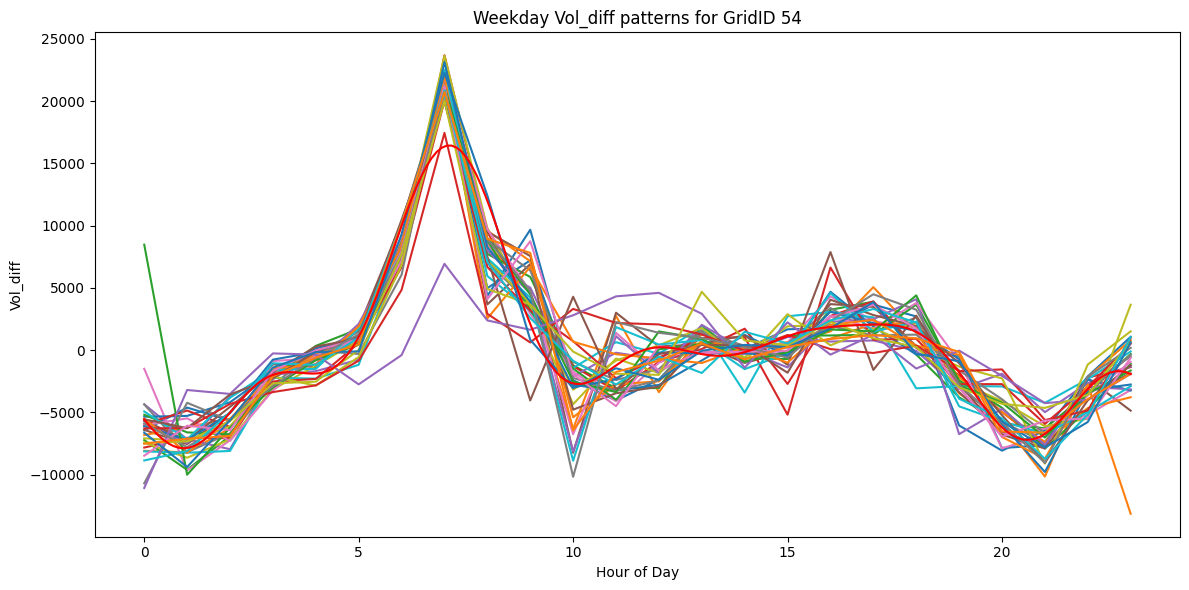

In [116]:
df_weekdays['date'] = df_weekdays['End_Time'].dt.date
df_weekdays['hour'] = df_weekdays['End_Time'].dt.hour  # or use End_Time directly if hourly

# Plot each day on the same graph
plt.figure(figsize=(12,6))
for date, group in df_weekdays.groupby('date'):
    plt.plot(group['hour'], group['Vol_diff'], label=str(date))

plt.plot(results['Weekdays']['hours'], results['Weekdays']['y_pred'], label=f"Fourier fit ({label})", color="red")

plt.xlabel("Hour of Day")
plt.ylabel("Vol_diff")
plt.title(f"Weekday Vol_diff patterns for GridID {grid_id}")
#plt.legend(title="Date", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
#edit

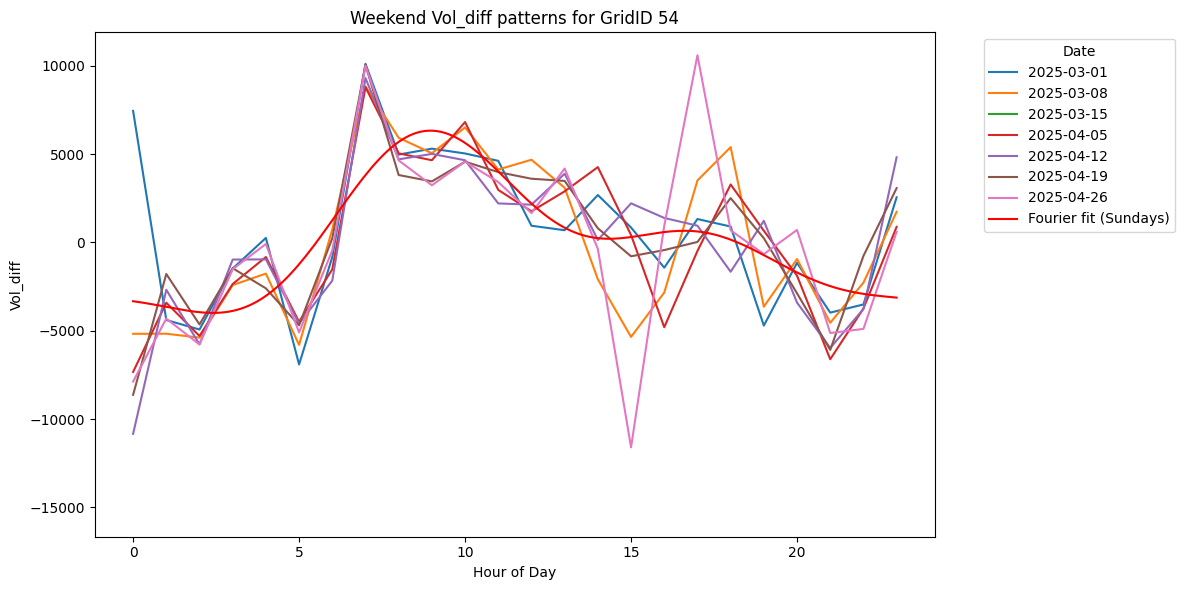

In [117]:
df_sat['date'] = df_sat['End_Time'].dt.date
df_sat['hour'] = df_sat['End_Time'].dt.hour  # or use End_Time directly if hourly

# Plot each day on the same graph
plt.figure(figsize=(12,6))
for date, group in df_sat.groupby('date'):
    plt.plot(group['hour'], group['Vol_diff'], label=str(date))

plt.plot(results['Saturdays']['hours'], results['Saturdays']['y_pred'], label=f"Fourier fit ({label})", color="red")

plt.xlabel("Hour of Day")
plt.ylabel("Vol_diff")
plt.title(f"Weekend Vol_diff patterns for GridID {grid_id}")
plt.legend(title="Date", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

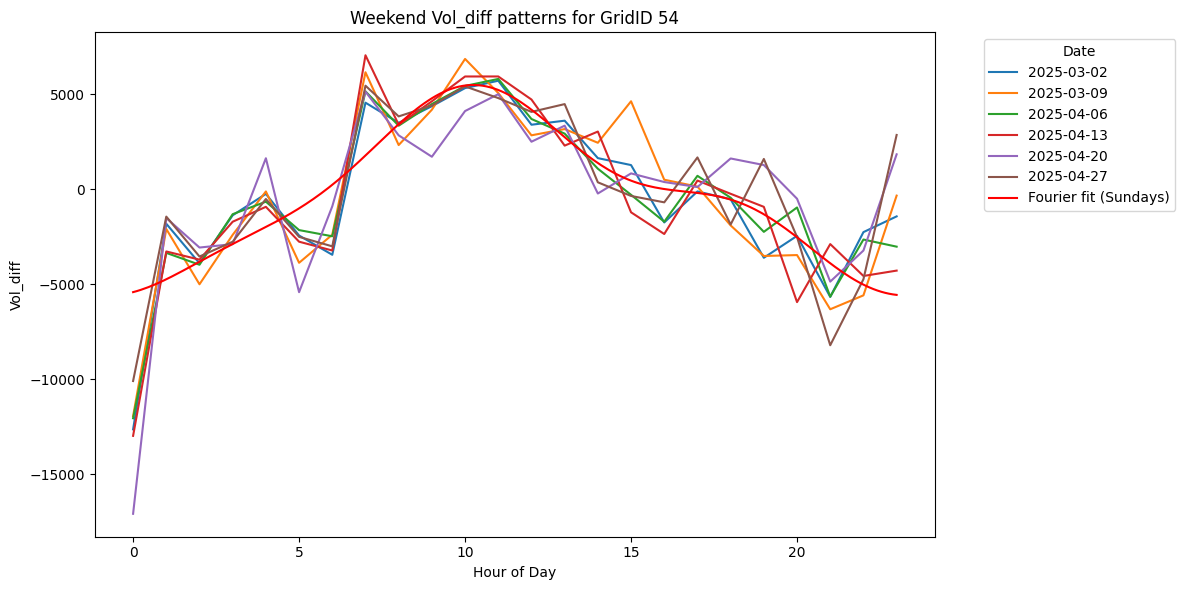

In [118]:

df_sun['date'] = df_sun['End_Time'].dt.date
df_sun['hour'] = df_sun['End_Time'].dt.hour  # or use End_Time directly if hourly

# Plot each day on the same graph
plt.figure(figsize=(12,6))
for date, group in df_sun.groupby('date'):
    plt.plot(group['hour'], group['Vol_diff'], label=str(date))

plt.plot(results['Sundays']['hours'], results['Sundays']['y_pred'], label=f"Fourier fit ({label})", color="red")

plt.xlabel("Hour of Day")
plt.ylabel("Vol_diff")
plt.title(f"Weekend Vol_diff patterns for GridID {grid_id}")
plt.legend(title="Date", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [133]:
# Dictionary to hold Fourier fit results
all_results = {}

# Collect mean reversion stats in a list
records = []

# Loop over every Grid_ID
for grid_id in joined_eval["Grid_ID"].unique():
    # Split this grid's data into weekdays, Saturday, Sunday
    df_weekdays = weekdays[weekdays["Grid_ID"] == grid_id].copy()
    df_sat = saturdays[saturdays["Grid_ID"] == grid_id].copy()
    df_sun = sundays[sundays["Grid_ID"] == grid_id].copy()

    # Skip if grid has no data at all
    if df_weekdays.empty and df_sat.empty and df_sun.empty:
        continue

    # Organize groups
    groups = {
        "Weekdays": df_weekdays,
        "Saturdays": df_sat,
        "Sundays": df_sun
    }

    # Choose harmonics per group
    harmonics_map = {
        "Weekdays": 6,
        "Saturdays": 4,
        "Sundays": 4
    }

    grid_results = {}

    # Fit and save Fourier models for each group
    for label, df in groups.items():
        if df.empty:
            continue  # skip missing groups

        n_harmonics = harmonics_map[label]
        hourly, hours, y_pred, model = fit_fourier(df, n_harmonics=n_harmonics)

        # Save fits in all_results
        grid_results[label] = {
            "hourly": hourly,
            "hours": hours,
            "y_pred": y_pred,
            "model": model,
            "n_harmonics": n_harmonics
        }

        # --- Mean reversion stats ---
        df = df.copy()
        df["hour"] = pd.to_datetime(df["End_Time"]).dt.hour

        # Build design matrix for raw df
        X = []
        for k in range(1, n_harmonics+1):
            X.append(pd.DataFrame({
                f'sin{k}': np.sin(2*np.pi*k*df['hour']/24),
                f'cos{k}': np.cos(2*np.pi*k*df['hour']/24)
            }))
        X = pd.concat(X, axis=1)

        df["fitted"] = model.predict(X)
        df["residuals"] = df["Vol_diff"] - df["fitted"]
        residuals = df["residuals"].values

        # ADF test
        try:
            adf_stat, p_val, *_ = adfuller(residuals)
        except Exception:
            adf_stat, p_val = None, None

        # AR(1) beta
        if len(residuals) > 1:
            r, r_next = residuals[:-1], residuals[1:]
            ar1_model = sm.OLS(r_next, sm.add_constant(r)).fit()
            beta = ar1_model.params[1]
        else:
            beta = None

        records.append({
            "Grid_ID": grid_id,
            "Group": label,
            "ADF_stat": adf_stat,
            "ADF_pval": p_val,
            "AR1_beta": beta
        })

    # Save all group results under this Grid_ID
    all_results[grid_id] = grid_results

# Convert mean reversion stats to dataframe
MeanReversionStats = pd.DataFrame(records)

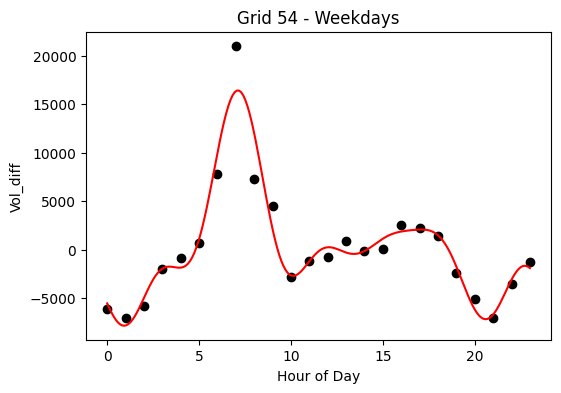

In [136]:

Grid = 54
gridxx_weekdays = all_results[Grid]["Weekdays"]

plt.figure(figsize=(6,4))
plt.scatter(gridxx_weekdays["hourly"]['hour'], gridxx_weekdays["hourly"]['Vol_diff'], color="black")
plt.plot(gridxx_weekdays["hours"], gridxx_weekdays["y_pred"], color="red")
plt.title(f"Grid {Grid} - Weekdays")
plt.xlabel("Hour of Day")
plt.ylabel("Vol_diff")
plt.show()


In [126]:
records = []

# Loop through all results
for grid_id, grid_results in all_results.items():
    for label, res in grid_results.items():
        hours = res["hours"]
        y_pred = res["y_pred"]
        area = trapz(y_pred, hours)

        records.append({
            "Grid_ID": grid_id,
            "Group": label,
            "Integral": area
        })

# Convert to dataframe
Fit_Integrals = pd.DataFrame(records)

C:\Users\user1\AppData\Local\Temp\ipykernel_10676\1076102971.py:8: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = trapz(y_pred, hours)


In [127]:
Fit_Integrals

,Grid_ID,Group,Integral
0,3.0,Weekdays,574.271861
1,3.0,Saturdays,294.851193
2,3.0,Sundays,82.761526
3,4.0,Weekdays,627.199277
4,4.0,Saturdays,285.308077
...,...,...,...
205,98.0,Saturdays,728.059662
206,98.0,Sundays,241.430255
207,99.0,Weekdays,249.729964
208,99.0,Saturdays,-82.535027


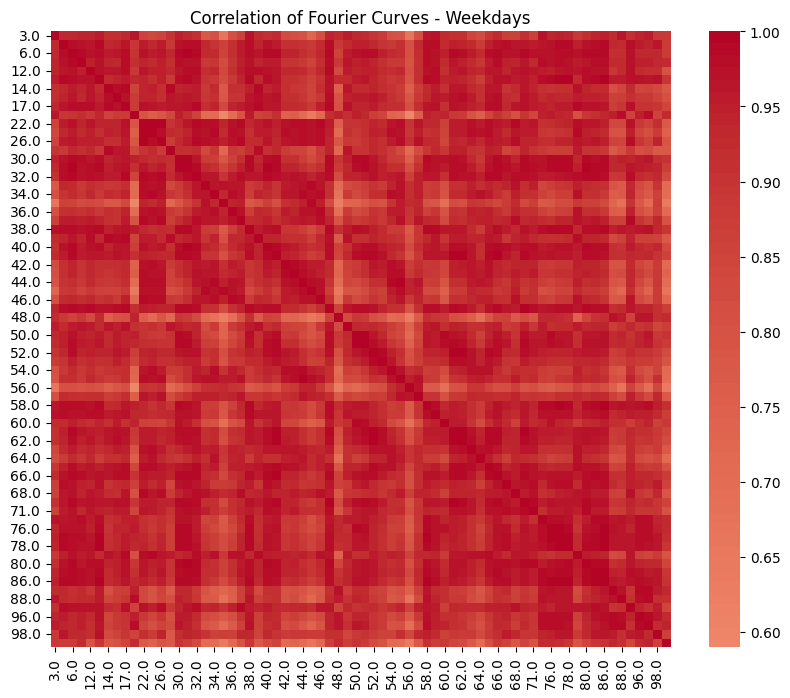

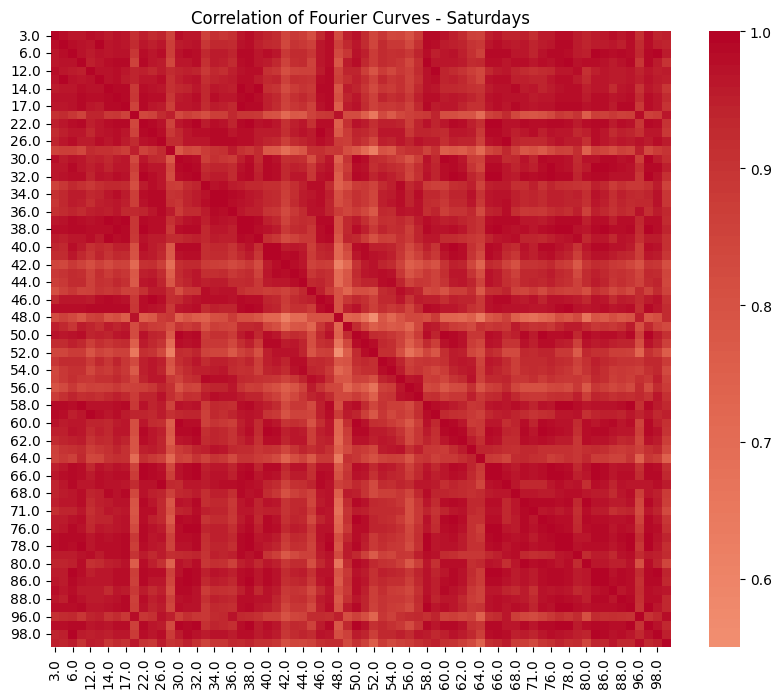

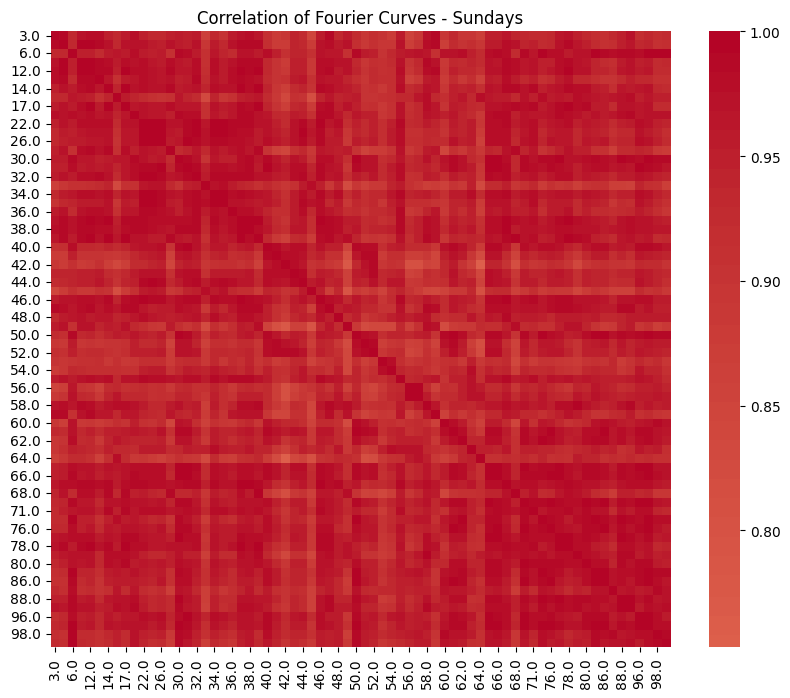

In [128]:
reference_hours = next(iter(next(iter(all_results.values())).values()))["hours"]

for group in ["Weekdays", "Saturdays", "Sundays"]:
    curves = {}

    # Collect fitted curves for each grid
    for grid_id, grid_results in all_results.items():
        if group in grid_results:
            res = grid_results[group]
            # y_pred should already be aligned with hours
            curves[grid_id] = res["y_pred"]

    # Build DataFrame: each column = grid_id, each row = predicted value at given hour
    df_curves = pd.DataFrame(curves, index=reference_hours)

    # Correlation across Grid_IDs
    corr = df_curves.corr()

    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, cmap="coolwarm", center=0)
    plt.title(f"Correlation of Fourier Curves - {group}")
    plt.show()

In [137]:
MeanReversionStats

,Grid_ID,Group,ADF_stat,ADF_pval,AR1_beta
0,3.0,Weekdays,-10.308699,3.227734e-18,0.155061
1,3.0,Saturdays,-4.778492,5.977957e-05,-0.056058
2,3.0,Sundays,-9.679068,1.218379e-16,-0.055744
3,4.0,Weekdays,-14.701783,2.938913e-27,-0.174970
4,4.0,Saturdays,-12.977656,2.989171e-24,-0.373420
...,...,...,...,...,...
205,98.0,Saturdays,-9.954345,2.466828e-17,-0.052525
206,98.0,Sundays,-12.506709,2.730448e-23,-0.411746
207,99.0,Weekdays,-7.452492,5.622646e-11,-0.220049
208,99.0,Saturdays,-12.036575,2.794296e-22,-0.073655


In [138]:
print("ADF_pval summary:")
print(MeanReversionStats["ADF_pval"].describe())

print("\nAR1_beta summary:")
print(MeanReversionStats["AR1_beta"].describe())

ADF_pval summary:
count    2.100000e+02
mean     3.162600e-05
std      2.840106e-04
min      0.000000e+00
25%      9.020195e-21
50%      1.019141e-16
75%      2.920228e-09
max      4.015988e-03
Name: ADF_pval, dtype: float64

AR1_beta summary:
count    210.000000
mean      -0.205526
std        0.175793
min       -0.641791
25%       -0.303127
50%       -0.185094
75%       -0.085087
max        0.231017
Name: AR1_beta, dtype: float64


In [148]:
may_groups = {
    "Weekdays": may_weekdays,
    "Saturdays": may_saturdays,
    "Sundays": may_sundays
}

may_records = []

for grid_id, grid_results in all_results.items():
    for label, res in grid_results.items():
        # Grab May data for this group
        if label not in may_groups:
            continue
        df = may_groups[label]
        df = df[df["Grid_ID"] == grid_id].copy()
        if df.empty:
            continue

        n_harmonics = res["n_harmonics"]
        model = res["model"]

        # Build Fourier features for May data
        df["hour"] = pd.to_datetime(df["End_Time"]).dt.hour
        X_may = []
        for k in range(1, n_harmonics+1):
            X_may.append(pd.DataFrame({
                f'sin{k}': np.sin(2*np.pi*k*df['hour']/24),
                f'cos{k}': np.cos(2*np.pi*k*df['hour']/24)
            }))
        X_may = pd.concat(X_may, axis=1)

        # Predict
        df["fitted"] = model.predict(X_may)

        # Store metrics
        mse = mean_squared_error(df["Vol_diff"], df["fitted"])
        r2 = r2_score(df["Vol_diff"], df["fitted"])

        may_records.append({
            "Grid_ID": grid_id,
            "Group": label,
            "RMSE": np.sqrt(mse),
            "R2": r2
        })

MayFitStats = pd.DataFrame(may_records)


In [149]:
MayFitStats

,Grid_ID,Group,RMSE,R2
0,3.0,Weekdays,225.814883,0.785398
1,3.0,Saturdays,167.290078,0.799414
2,3.0,Sundays,133.663432,0.816237
3,4.0,Weekdays,232.841126,0.716505
4,4.0,Saturdays,183.743570,0.711806
...,...,...,...,...
205,98.0,Saturdays,307.147878,0.797934
206,98.0,Sundays,263.076541,0.829831
207,99.0,Weekdays,121.526792,0.693455
208,99.0,Saturdays,154.731034,0.521501


In [154]:
print("=== May RMSE summary by Group ===")
print(MayFitStats.groupby("Group")["RMSE"].describe(), "\n")

print("=== May R2 summary by Group ===")
print(MayFitStats.groupby("Group")["R2"].describe())

=== May RMSE summary by Group ===
           count        mean         std        min         25%         50%  \
Group                                                                         
Saturdays   70.0  593.064663  545.370345  68.053741  246.907809  402.790774   
Sundays     70.0  485.520312  465.410387  28.344868  217.543545  343.843555   
Weekdays    70.0  600.964362  538.658754  84.645189  285.850581  467.623819   

                  75%          max  
Group                               
Saturdays  735.490655  2564.495613  
Sundays    564.510087  2306.719771  
Weekdays   660.964267  3247.939657   

=== May R2 summary by Group ===
           count      mean       std       min       25%       50%       75%  \
Group                                                                          
Saturdays   70.0  0.670034  0.180594  0.088623  0.530836  0.730166  0.810149   
Sundays     70.0  0.749556  0.137879  0.202630  0.708491  0.794351  0.841645   
Weekdays    70.0  0.783681  0.1

In [151]:
reversion_records = []

for grid_id, grid_results in all_results.items():
    for label, res in grid_results.items():
        # Grab May data for this group
        if label not in may_groups:
            continue
        df = may_groups[label]
        df = df[df["Grid_ID"] == grid_id].copy()
        if df.empty:
            continue

        n_harmonics = res["n_harmonics"]
        model = res["model"]

        # Build Fourier features for May data
        df["hour"] = pd.to_datetime(df["End_Time"]).dt.hour
        X_may = []
        for k in range(1, n_harmonics+1):
            X_may.append(pd.DataFrame({
                f'sin{k}': np.sin(2*np.pi*k*df['hour']/24),
                f'cos{k}': np.cos(2*np.pi*k*df['hour']/24)
            }))
        X_may = pd.concat(X_may, axis=1)

        # Residuals (May data vs old Fourier fit)
        df["fitted"] = model.predict(X_may)
        df["residuals"] = df["Vol_diff"] - df["fitted"]
        residuals = df["residuals"].values

        # --- Mean reversion tests ---
        try:
            adf_stat, p_value, *_ = adfuller(residuals)
        except Exception:
            adf_stat, p_value = None, None

        if len(residuals) > 1:
            r, r_next = residuals[:-1], residuals[1:]
            ar1_model = sm.OLS(r_next, sm.add_constant(r)).fit()
            beta = ar1_model.params[1]
        else:
            beta = None

        reversion_records.append({
            "Grid_ID": grid_id,
            "Group": label,
            "ADF_stat": adf_stat,
            "ADF_pval": p_value,
            "AR1_beta": beta
        })

# Collect results
MayMeanReversionStats = pd.DataFrame(reversion_records)

In [152]:
MayMeanReversionStats

,Grid_ID,Group,ADF_stat,ADF_pval,AR1_beta
0,3.0,Weekdays,-9.588687,2.063904e-16,0.135820
1,3.0,Saturdays,-11.805806,9.102506e-22,-0.085344
2,3.0,Sundays,-11.654613,1.999284e-21,-0.202306
3,4.0,Weekdays,-9.352613,8.218258e-16,-0.099265
4,4.0,Saturdays,-10.043104,1.478390e-17,0.040421
...,...,...,...,...,...
205,98.0,Saturdays,-7.673745,1.568636e-11,-0.040662
206,98.0,Sundays,-8.518985,1.113912e-13,-0.033229
207,99.0,Weekdays,-10.660783,4.412949e-19,-0.146160
208,99.0,Saturdays,-14.980328,1.164682e-27,-0.368628


In [153]:
print("ADF_pval summary:")
print(MayMeanReversionStats["ADF_pval"].describe())

print("\nAR1_beta summary:")
print(MayMeanReversionStats["AR1_beta"].describe())

ADF_pval summary:
count    2.100000e+02
mean     1.008846e-04
std      9.860747e-04
min      1.016388e-27
25%      2.782300e-18
50%      5.862012e-14
75%      2.774588e-10
max      1.186137e-02
Name: ADF_pval, dtype: float64

AR1_beta summary:
count    210.000000
mean      -0.196107
std        0.171512
min       -0.567914
25%       -0.319303
50%       -0.203799
75%       -0.085827
max        0.432672
Name: AR1_beta, dtype: float64


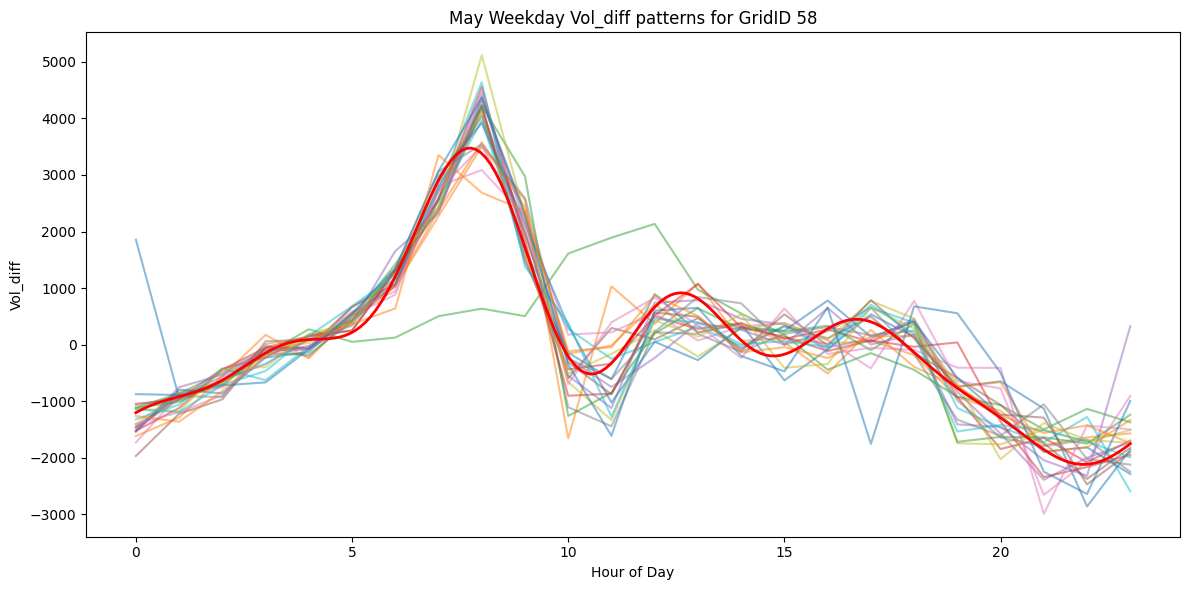

In [159]:
grid_id=58
label = "Weekdays"

# Get May weekday data for this grid
df_may_weekdays = may_weekdays[may_weekdays["Grid_ID"] == grid_id].copy()
df_may_weekdays["date"] = pd.to_datetime(df_may_weekdays["End_Time"]).dt.date
df_may_weekdays["hour"] = pd.to_datetime(df_may_weekdays["End_Time"]).dt.hour

plt.figure(figsize=(12,6))

# Plot each May weekday separately
for date, group in df_may_weekdays.groupby("date"):
    plt.plot(group["hour"], group["Vol_diff"], alpha=0.5, label=str(date))

# Overlay Fourier best fit from earlier training
res = all_results[grid_id][label]
plt.plot(res["hours"], res["y_pred"], color="red", linewidth=2, label="Fourier Fit (Weekdays)")

plt.xlabel("Hour of Day")
plt.ylabel("Vol_diff")
plt.title(f"May Weekday Vol_diff patterns for GridID {grid_id}")
# plt.legend(title="Date", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

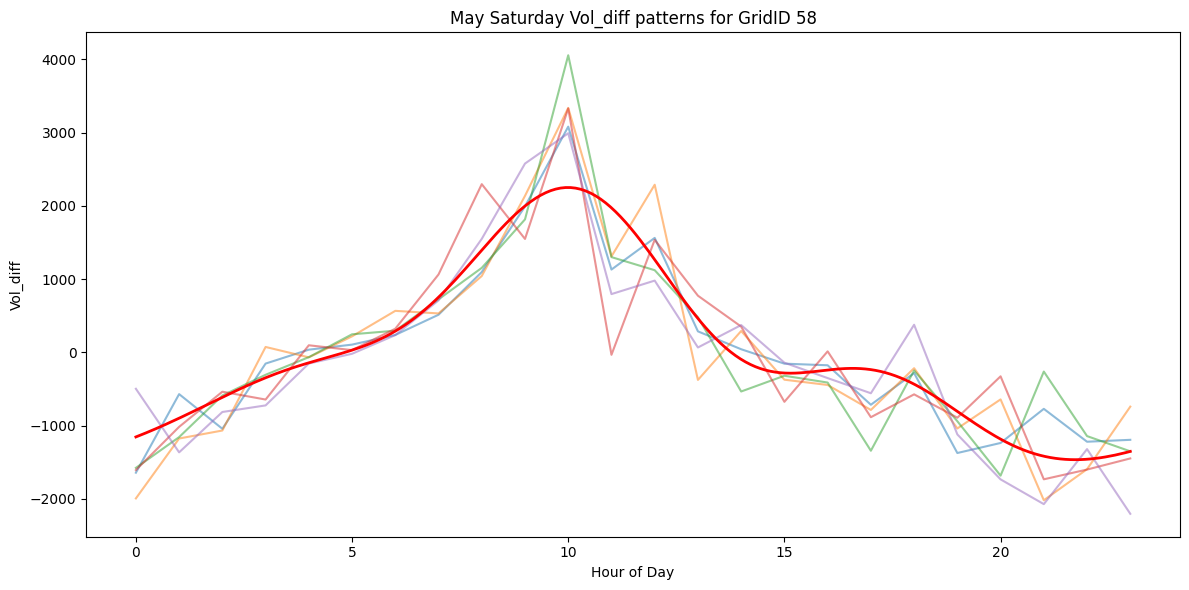

In [160]:
label = "Saturdays"

# Get May Saturday data for this grid
df_may_sat = may_saturdays[may_saturdays["Grid_ID"] == grid_id].copy()
df_may_sat["date"] = pd.to_datetime(df_may_sat["End_Time"]).dt.date
df_may_sat["hour"] = pd.to_datetime(df_may_sat["End_Time"]).dt.hour

plt.figure(figsize=(12,6))

# Plot each May Saturday separately
for date, group in df_may_sat.groupby("date"):
    plt.plot(group["hour"], group["Vol_diff"], alpha=0.5, label=str(date))

# Overlay Fourier best fit from earlier training
res = all_results[grid_id][label]
plt.plot(res["hours"], res["y_pred"], color="red", linewidth=2, label="Fourier Fit (Saturdays)")

plt.xlabel("Hour of Day")
plt.ylabel("Vol_diff")
plt.title(f"May Saturday Vol_diff patterns for GridID {grid_id}")
# plt.legend(title="Date", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

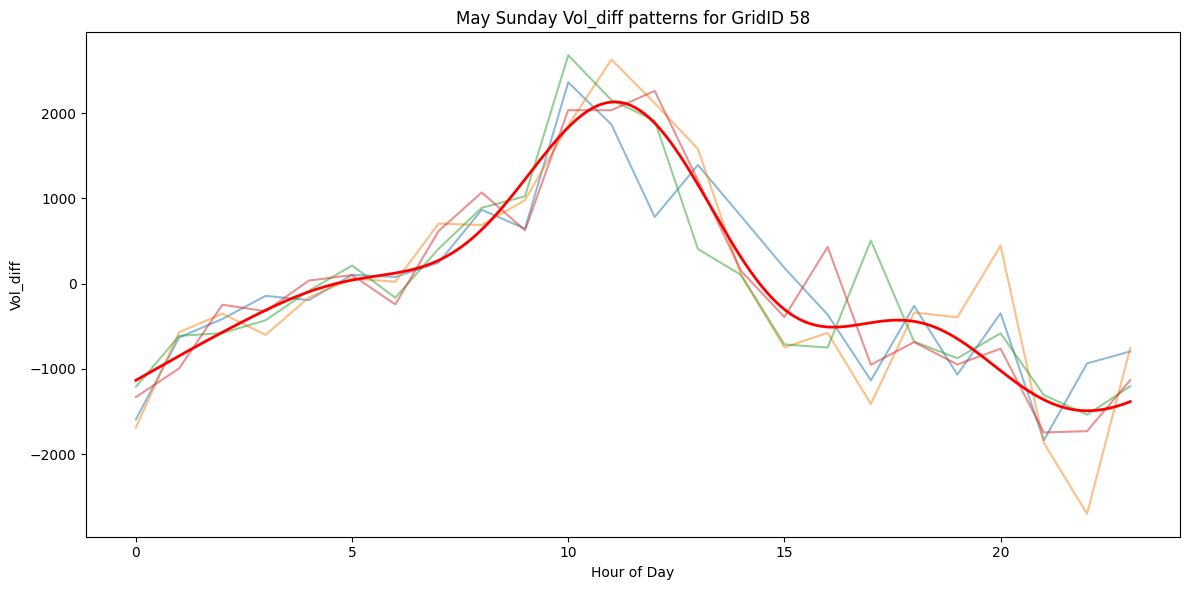

In [161]:
label = "Sundays"

# Get May Sunday data for this grid
df_may_sun = may_sundays[may_sundays["Grid_ID"] == grid_id].copy()
df_may_sun["date"] = pd.to_datetime(df_may_sun["End_Time"]).dt.date
df_may_sun["hour"] = pd.to_datetime(df_may_sun["End_Time"]).dt.hour

plt.figure(figsize=(12,6))

# Plot each May Sunday separately
for date, group in df_may_sun.groupby("date"):
    plt.plot(group["hour"], group["Vol_diff"], alpha=0.5, label=str(date))

# Overlay Fourier best fit from earlier training
res = all_results[grid_id][label]
plt.plot(res["hours"], res["y_pred"], color="red", linewidth=2, label="Fourier Fit (Sundays)")

plt.xlabel("Hour of Day")
plt.ylabel("Vol_diff")
plt.title(f"May Sunday Vol_diff patterns for GridID {grid_id}")
# plt.legend(title="Date", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [172]:
def forecast_with_mean_reversion(df, model, n_harmonics, cutoff_hour):
    df = df.copy()
    df["hour"] = pd.to_datetime(df["End_Time"]).dt.hour

    # Build Fourier features
    X_all = []
    for k in range(1, n_harmonics+1):
        X_all.append(pd.DataFrame({
            f'sin{k}': np.sin(2*np.pi*k*df['hour']/24),
            f'cos{k}': np.cos(2*np.pi*k*df['hour']/24)
        }))
    X_all = pd.concat(X_all, axis=1)

    df["fitted"] = model.predict(X_all)
    df["residuals"] = df["Vol_diff"] - df["fitted"]

    # Split early vs late
    df_early = df[df["hour"] <= cutoff_hour]
    df_late = df[df["hour"] > cutoff_hour]

    if df_early.empty or df_late.empty or len(df_early) < 2:
        return df_early, df_late, None, None   # <-- always 4 outputs

    # Fit AR(1) on early residuals
    r = df_early["residuals"].values
    r_lag, r_next = r[:-1], r[1:]
    ar1_model = sm.OLS(r_next, sm.add_constant(r_lag)).fit()

    # Forecast residual path for late hours
    last_resid = r[-1]
    forecast_resids = []
    for _ in range(len(df_late)):
        last_resid = ar1_model.params[0] + ar1_model.params[1]*last_resid
        forecast_resids.append(last_resid)

    df_late["adjusted_pred"] = df_late["fitted"].values + np.array(forecast_resids)

    # Metrics for late part only
    rmse = np.sqrt(mean_squared_error(df_late["Vol_diff"], df_late["adjusted_pred"]))
    r2 = r2_score(df_late["Vol_diff"], df_late["adjusted_pred"])

    return df_early, df_late, rmse, r2 


In [ ]:
comp_records = []
may_groups = {
    "Weekdays": may_weekdays,
    "Saturdays": may_saturdays,
    "Sundays": may_sundays
}

for grid_id, grid_results in all_results.items():
    for label, res in grid_results.items():
        if label not in may_groups:
            continue
        df = may_groups[label]
        df = df[df["Grid_ID"] == grid_id].copy()
        if df.empty:
            continue

        _, _, rmse, r2 = forecast_with_mean_reversion(
            df=df,
            model=res["model"],
            n_harmonics=res["n_harmonics"],
            cutoff_hour=12   # can change cutoff
        )

        if rmse is not None:
            comp_records.append({
                "Grid_ID": grid_id,
                "Group": label,
                "CutoffHour": 12,
                "RMSE": rmse,
                "R2": r2
            })

MayMeanReversionFitStats = pd.DataFrame(comp_records)

C:\Users\user1\AppData\Local\Temp\ipykernel_10676\2912442766.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_late["adjusted_pred"] = df_late["fitted"].values + np.array(forecast_resids)
C:\Users\user1\AppData\Local\Temp\ipykernel_10676\2912442766.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_late["adjusted_pred"] = df_late["fitted"].values + np.array(forecast_resids)
C:\Users\user1\AppData\Local\Temp\ipykernel_10676\2912442766.py:36: SettingWithCopyWarning: 
A value is trying to be set on 

In [175]:
MayMeanReversionFitStats

,Grid_ID,Group,CutoffHour,RMSE,R2
0,3.0,Weekdays,12,266.552788,0.644484
1,3.0,Saturdays,12,169.892572,0.376925
2,3.0,Sundays,12,175.228686,0.540165
3,4.0,Weekdays,12,252.265467,0.440322
4,4.0,Saturdays,12,215.359323,0.031841
...,...,...,...,...,...
205,98.0,Saturdays,12,345.584207,0.445872
206,98.0,Sundays,12,273.055941,0.620967
207,99.0,Weekdays,12,120.267412,0.672795
208,99.0,Saturdays,12,105.317312,0.397953


In [178]:
print("=== May RMSE summary by Group ===")
print(MayMeanReversionFitStats.groupby("Group")["RMSE"].describe(), "\n")

print("=== May R2 summary by Group ===")
print(MayMeanReversionFitStats.groupby("Group")["R2"].describe())

=== May RMSE summary by Group ===
           count        mean         std        min         25%         50%  \
Group                                                                         
Saturdays   70.0  600.263918  526.614675  67.967972  278.564124  449.929048   
Sundays     70.0  520.404687  497.996766  31.912200  226.578244  359.725366   
Weekdays    70.0  571.851854  576.121395  61.017249  270.781171  402.474710   

                  75%          max  
Group                               
Saturdays  725.534621  2396.639896  
Sundays    621.540068  2439.966705  
Weekdays   595.519808  3529.326099   

=== May R2 summary by Group ===
           count      mean       std       min       25%       50%       75%  \
Group                                                                          
Saturdays   70.0  0.325880  0.243471 -0.896744  0.158502  0.358612  0.494835   
Sundays     70.0  0.565515  0.192659 -0.080566  0.471079  0.622693  0.694018   
Weekdays    70.0  0.619491  0.1